In [1]:
from dpks.quant_matrix import QuantMatrix
from dpks.classification import Classifier

/home/erikh/dpks/test-venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
qm = QuantMatrix(
    quantification_file="../tests/input_files/data_sepsis.tsv",
    design_matrix_file="../tests/input_files/design_sepsis.tsv")



In [3]:
quantified_data = (
    qm.normalize(
        method="mean",
    )
    .quantify(method="top_n")
)


In [4]:
clf = Classifier(quantitative_data = quantified_data, classifier='xgboost')
clf.cross_validation(k_folds=5)

0.83 accuracy with a standard deviation of 0.13


This should equals the height of the Feature 232-bar:  1.1797652497127415


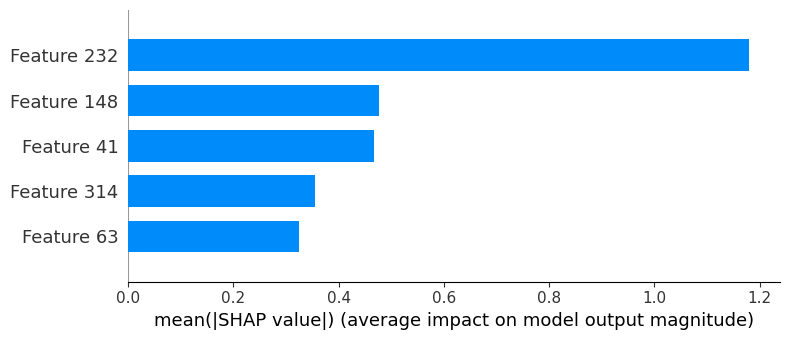

In [5]:
quantified_data = clf.interpret(quantified_data, algorithm = 'auto')
print("This should equals the height of the Feature 232-bar: ", quantified_data.quantitative_data.obs['SHAP'][232])
import shap

shap.summary_plot(clf.shap_values, clf.X, max_display=5, plot_type='bar')

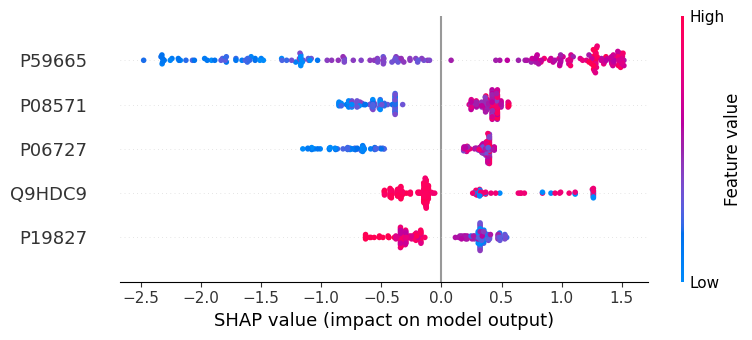

In [6]:
shap.summary_plot(clf.shap_values, clf.X, max_display=5, feature_names = quantified_data.quantitative_data.obs['Protein'])

In [7]:
clf.recursive_feature_elimination()

Number of selected features: 44
[ True False False False False False False False False False  True False
 False False False False False False False False False False False False
 False  True False False False False False False  True False False  True
 False False False False False  True False False False False False False
 False False False False False False False False False False False False
  True  True  True  True False False False False False False False False
 False False False False False False  True False False False False False
 False  True False False False False False False False False False False
 False False False False False False False False False  True False False
 False False False False False False False False False False  True False
 False False  True False False False False False  True False False False
 False False False False False False False False False False  True False
 False False False False  True False False False False  True False False
 False False False 